<a href="https://colab.research.google.com/github/chad-fisher/KansasWind/blob/main/KansasWindfarms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# Install needed packages on environment
!pip install matplotlib_scalebar contextily wget rasterstats rioxarray geocube

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 kB 10.6 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=fd104c164f40efd5a6c704b26945516e7b243be5984e4833b1bfcd5d3b367c18
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
# Install spatial RF package from GitHub
!pip install git+https://github.com/mie-lab/spatial_rf_python.git#egg=sprf

  Cloning https://github.com/mie-lab/spatial_rf_python.git to /tmp/pip-install-lwtom1lx/sprf_9225c7896d44475ca3e2d9a6faed11c3
  Running command git clone --filter=blob:none --quiet https://github.com/mie-lab/spatial_rf_python.git /tmp/pip-install-lwtom1lx/sprf_9225c7896d44475ca3e2d9a6faed11c3
  Resolved https://github.com/mie-lab/spatial_rf_python.git to commit 20d88253883492d81e62ae550a01ff2b8aaeed26
  Preparing metadata (setup.py) ... done
  Created wheel for sprf: filename=sprf-0.0.1-py3-none-any.whl size=9870 sha256=b4884127312c94c56e75abd2f403755e181c493244ae451f023c907c3661d1af
  Stored in directory: /tmp/pip-ephem-wheel-cache-poihp4wl/wheels/8b/86/d5/fb2c74a3279dd89ff1d61d803d6aa49e21319509e573968048
Successfully built sprf


In [3]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import scipy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import contextily as cx

import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling

import wget
import zipfile
import datetime
import urllib
import rasterstats
import glob

import sprf
from sprf.spatial_random_forest import SpatialRandomForest
from sprf.geographical_random_forest import GeographicalRandomForest

import rioxarray as rxr
import xarray
import fiona

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from shapely.geometry import Point

from geocube.api.core import make_geocube

In [4]:
# Get Cleaned Data from ArcGIS
!wget "https://tufts.box.com/shared/static/jr0cmw6ft5vvkd8gkdjcexva5pfqsald.zip"
zipfile.ZipFile('/content/jr0cmw6ft5vvkd8gkdjcexva5pfqsald.zip').extractall()

--2024-04-22 18:12:40--  https://tufts.box.com/shared/static/jr0cmw6ft5vvkd8gkdjcexva5pfqsald.zip
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/jr0cmw6ft5vvkd8gkdjcexva5pfqsald.zip [following]
--2024-04-22 18:12:40--  https://tufts.box.com/public/static/jr0cmw6ft5vvkd8gkdjcexva5pfqsald.zip
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/jr0cmw6ft5vvkd8gkdjcexva5pfqsald.zip [following]
--2024-04-22 18:12:40--  https://tufts.app.box.com/public/static/jr0cmw6ft5vvkd8gkdjcexva5pfqsald.zip
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

# Data Collection and Cleaning

## Wind Turbine Data

In [5]:
#Get Wind Turbine Data
!wget "https://eerscmap.usgs.gov/uswtdb/assets/data/uswtdbSHP.zip"
zipfile.ZipFile('uswtdbSHP.zip').extractall(path='/content/WTDB')

--2024-04-22 18:13:34--  https://eerscmap.usgs.gov/uswtdb/assets/data/uswtdbSHP.zip
Resolving eerscmap.usgs.gov (eerscmap.usgs.gov)... 137.227.248.56, 2001:49c8:0:126d::56
Connecting to eerscmap.usgs.gov (eerscmap.usgs.gov)|137.227.248.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4265263 (4.1M) [application/zip]
Saving to: ‘uswtdbSHP.zip’

uswtdbSHP.zip       100%[===================>]   4.07M  7.51MB/s    in 0.5s    

2024-04-22 18:13:35 (7.51 MB/s) - ‘uswtdbSHP.zip’ saved [4265263/4265263]



In [6]:
# Open, subset, and reproject KS wind turbines
path='/content/WTDB/uswtdb_v6_1_20231128.shp'
KS_WT = gpd.read_file(path)[gpd.read_file(path)['t_state'] == 'KS']
KansasWindTurbines_Reprojected = KS_WT.to_crs(epsg=3857)

## State Data

In [7]:
# Get State outlines from census
!wget "https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip"
zipfile.ZipFile('tl_2023_us_state.zip').extractall(path='/content/States')

--2024-04-22 18:14:31--  https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip
Resolving www2.census.gov (www2.census.gov)... 104.98.81.97, 2600:1407:1800:3a2::208c, 2600:1407:1800:38b::208c
Connecting to www2.census.gov (www2.census.gov)|104.98.81.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘tl_2023_us_state.zip’

tl_2023_us_state.zi     [ <=>                ]   9.49M  49.0MB/s    in 0.2s    

2024-04-22 18:14:32 (49.0 MB/s) - ‘tl_2023_us_state.zip’ saved [9947818]



In [8]:
StatesMap = gpd.read_file('/content/States/tl_2023_us_state.shp')

In [9]:
# Extract Kansas boundaries
KS_StateMap = StatesMap[StatesMap['NAME'] == 'Kansas']

## Wind Turbine Map

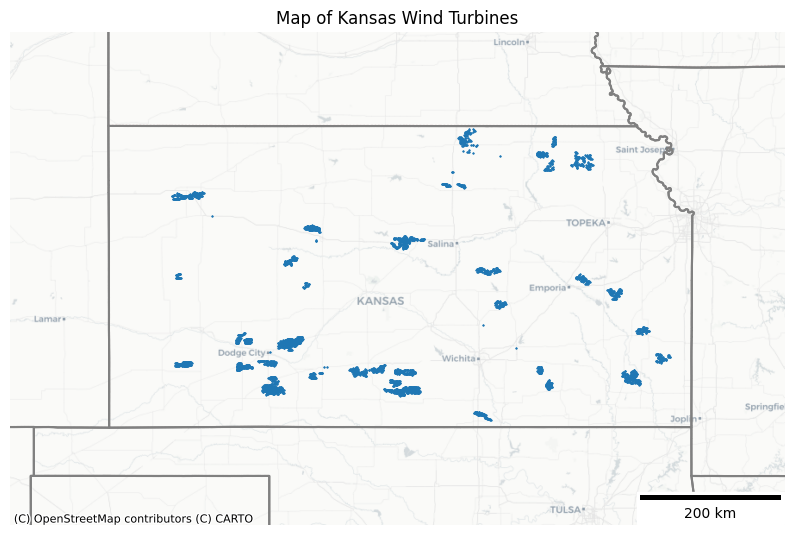

In [10]:
# Generate map
ax = KS_WT.to_crs(epsg=3857).plot(figsize=(10,10),marker='*',markersize=0.5)
StatesMap.to_crs(epsg=3857).boundary.plot(ax=ax, color = 'gray')

#Change zoom/extent of map using coordinates in relevant CRS
plt.xlim(-1.15e7, -1.04e7)
plt.ylim(4.3e6, 5e6)

#Modify and save map
plt.title("Map of Kansas Wind Turbines")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig("KansasWindTurbinesMap.png")

## Land Cover Data

In [11]:
# Get NLCD data
!wget "https://s3-us-west-2.amazonaws.com/mrlc/nlcd_2021_land_cover_l48_20230630.zip"
zipfile.ZipFile('nlcd_2021_land_cover_l48_20230630.zip').extractall(path='/content/LandCover')

--2024-04-22 18:14:36--  https://s3-us-west-2.amazonaws.com/mrlc/nlcd_2021_land_cover_l48_20230630.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.239.88, 52.218.217.128, 52.92.236.216, ...
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.239.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1958811487 (1.8G) [application/zip]
Saving to: ‘nlcd_2021_land_cover_l48_20230630.zip’

nlcd_2021_land_cove 100%[===================>]   1.82G  45.7MB/s    in 41s     

2024-04-22 18:15:18 (45.5 MB/s) - ‘nlcd_2021_land_cover_l48_20230630.zip’ saved [1958811487/1958811487]



In [12]:
#open cleaned image from ArcGIS
KS_LandCover,trans = rio.mask.mask(rio.open('/content/Cleaned Data/KS_NLCD_Cleaned.tif'),KS_StateMap.to_crs(epsg=3857).geometry,crop=True, filled=False)

In [13]:
# Recode NLCD database codes to make them evenly spaced
recode=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
nlcd_codes = [0, 11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95]
for i in recode:
  KS_LandCover[KS_LandCover==nlcd_codes[i]]=i

In [14]:
# Create custom colormap based on recoded values
nlcd_colors = ['#ffffff', '#476ba0', '#d1def8', '#decaca', '#d99482', '#ee0000', '#ab0000',
               '#b3aea3', '#68ab63', '#1c6330', '#b5ca8f', '#a68c30', '#ccba7d', '#e3e3c2',
               '#caca78', '#99c247', '#78ae94']

cmap = mpl.colors.ListedColormap(nlcd_colors)
norm = mpl.colors.BoundaryNorm(recode,
                    len(nlcd_colors))

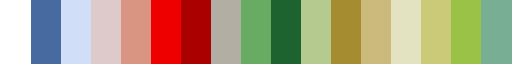

In [15]:
#Test colormap
cmap

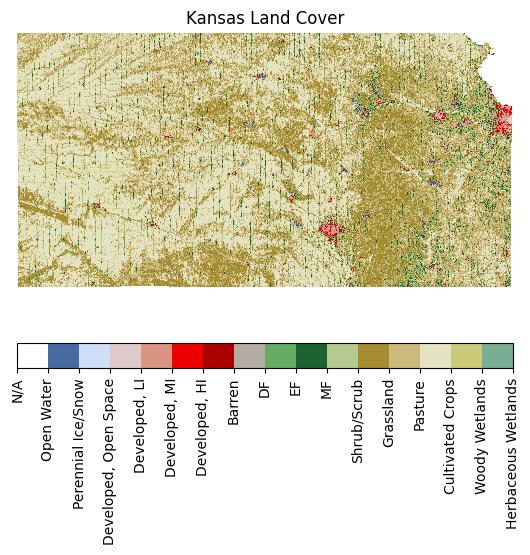

In [16]:
#Initialize plot
fig, ax = plt.subplots()
plt.title('Kansas Land Cover')

# Create hidden image for colorbar and actual image
hidden=ax.imshow(KS_LandCover[0,:,:],cmap=cmap,norm=norm)
show(KS_LandCover,ax=ax,cmap=cmap,norm=norm)
cbar= fig.colorbar(hidden, ticks=recode, ax=ax,location='bottom')
labels=['N/A','Open Water','Perennial Ice/Snow','Developed, Open Space','Developed, LI','Developed, MI','Developed, HI','Barren','DF','EF','MF','Shrub/Scrub','Grassland','Pasture','Cultivated Crops','Woody Wetlands','Herbaceous Wetlands']
cbar.set_ticks(ticks=recode,labels=labels)
cbar.ax.tick_params(rotation=90)

#Save plot as png
ax.set_axis_off()
fig.savefig('Kansas Land Cover.png')

## Wind Speed Data

In [17]:
# Download wind speed data
!wget 'https://globalwindatlas3.s3-eu-west-1.amazonaws.com/country_tifs/USA_wind-speed_10m.tif'

--2024-04-22 18:18:39--  https://globalwindatlas3.s3-eu-west-1.amazonaws.com/country_tifs/USA_wind-speed_10m.tif
Resolving globalwindatlas3.s3-eu-west-1.amazonaws.com (globalwindatlas3.s3-eu-west-1.amazonaws.com)... 3.5.64.170, 3.5.67.18, 52.218.106.192, ...
Connecting to globalwindatlas3.s3-eu-west-1.amazonaws.com (globalwindatlas3.s3-eu-west-1.amazonaws.com)|3.5.64.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702896032 (670M) [image/tiff]
Saving to: ‘USA_wind-speed_10m.tif’

USA_wind-speed_10m. 100%[===================>] 670.33M  26.3MB/s    in 27s     

2024-04-22 18:19:06 (24.9 MB/s) - ‘USA_wind-speed_10m.tif’ saved [702896032/702896032]



In [18]:
# Mask windspeed data
with rio.open('/content/USA_wind-speed_10m.tif') as src:
    out_meta = src.meta
    out_image, out_transform = rio.mask.mask(src, shapes=KS_StateMap.to_crs(4326).geometry, crop=True)


    profile = src.profile
    profile["height"] = out_image.shape[1]
    profile["width"] = out_image.shape[2]
    profile["transform"] = out_transform


    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open("wind2023.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [19]:
#Reproject windspeed data
dst_crs = 'EPSG:3857'

with rio.open('wind2023.tif') as src:

    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rio.Env(CHECK_DISK_FREE_SPACE="NO"):
        with rio.open('/content/WindSpeed_Reprojected.tif', 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [20]:
#Open reprojected and masked data
wind2023 = rio.open('WindSpeed_Reprojected.tif').read(1)

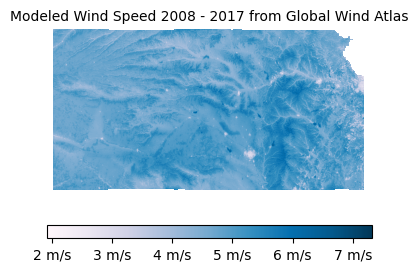

In [21]:
#Initialize plot
fig, ax =plt.subplots(figsize=(6,3))
plt.title('Modeled Wind Speed 2008 - 2017 from Global Wind Atlas',size = 'medium')

# Create hidden image for colorbar and actual image
hidden = ax.imshow(wind2023,cmap = 'PuBu')
img = show(wind2023, ax = ax, cmap = 'PuBu')
fig.colorbar(hidden, cmap = 'PuBu', shrink=.7, orientation = 'horizontal', aspect = 25, format = "%i m/s")

# Save plot
ax.axis('off')
fig.savefig('Wind Kansas Map')

## DEM Data

In [22]:
# Download DEM tiles
!wget 'https://tufts.box.com/shared/static/ti9me4c794p69w51ztfedwsu3au0r2qg.zip'
zipfile.ZipFile('/content/ti9me4c794p69w51ztfedwsu3au0r2qg.zip').extractall()

--2024-04-22 18:19:08--  https://tufts.box.com/shared/static/ti9me4c794p69w51ztfedwsu3au0r2qg.zip
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ti9me4c794p69w51ztfedwsu3au0r2qg.zip [following]
--2024-04-22 18:19:08--  https://tufts.box.com/public/static/ti9me4c794p69w51ztfedwsu3au0r2qg.zip
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/ti9me4c794p69w51ztfedwsu3au0r2qg.zip [following]
--2024-04-22 18:19:08--  https://tufts.app.box.com/public/static/ti9me4c794p69w51ztfedwsu3au0r2qg.zip
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

In [23]:
# Mosaic tiles
DEM_list=glob.glob('/content/DEM/*.tif')
src_files_to_mosaic = []
for fp in DEM_list:
  src = rio.open(fp)
  src_files_to_mosaic.append(src)
mosaic, out_trans = merge(src_files_to_mosaic)
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
"height": mosaic.shape[1],
"width": mosaic.shape[2],"transform": out_trans,"crs": "+proj=longlat +datum=WGS84 +no_defs"})

with rio.open("mosaic.tif", "w", **out_meta) as dest:
    dest.write(mosaic)

In [24]:
# tiles exported into ArcGIS and cleaned

In [25]:
# Import cleaned DEM mosaic
mos = rio.open('/content/Cleaned Data/DEM_Cleaned.tif')

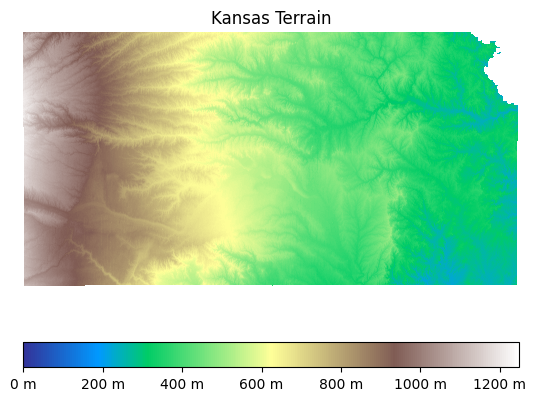

In [26]:
# Initialize plots
fig,ax=plt.subplots()

# Mask to Kansas
mosaic,trans=rio.mask.mask(mos, shapes=KS_StateMap.to_crs(3857).geometry, crop=True,filled=False,nodata=0)
plt.title('Kansas Terrain',size='large')

# Create hidden image for colorbar and actual image
hidden=ax.imshow(mosaic[0,:,:],cmap='terrain',vmin=0)
show(mosaic,cmap='terrain',ax=ax,vmin=0)
fig.colorbar(hidden,cmap='terrain',orientation='horizontal',format="%i m")

# Save plot
ax.axis('off')
fig.savefig('Terrain Map.png')

## Power Lines Data

In [27]:
# Download power lines data
!wget 'https://tufts.box.com/shared/static/lw7aasw5fvm7z60l6qh1p75h92bzt4j4.zip'
zipfile.ZipFile('/content/lw7aasw5fvm7z60l6qh1p75h92bzt4j4.zip').extractall(path = 'PowerLines')

--2024-04-22 18:20:23--  https://tufts.box.com/shared/static/lw7aasw5fvm7z60l6qh1p75h92bzt4j4.zip
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/lw7aasw5fvm7z60l6qh1p75h92bzt4j4.zip [following]
--2024-04-22 18:20:23--  https://tufts.box.com/public/static/lw7aasw5fvm7z60l6qh1p75h92bzt4j4.zip
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/lw7aasw5fvm7z60l6qh1p75h92bzt4j4.zip [following]
--2024-04-22 18:20:23--  https://tufts.app.box.com/public/static/lw7aasw5fvm7z60l6qh1p75h92bzt4j4.zip
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

In [28]:
# Read power lines data
powerLines = gpd.read_file('/content/PowerLines/Electric_Power_Transmission_Lines_A.shp')

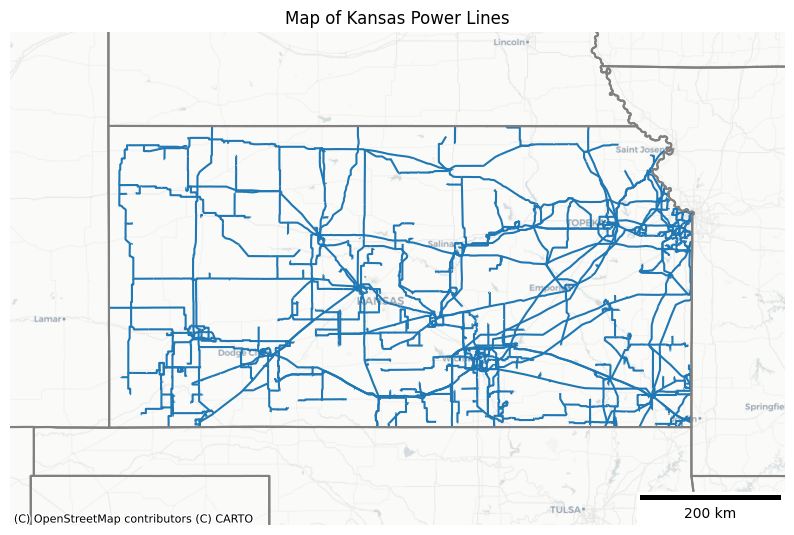

In [29]:
# Make map
ax = powerLines.to_crs(epsg=3857).clip(KS_StateMap.to_crs(epsg=3857)).plot(figsize=(10,10))
StatesMap.to_crs(epsg=3857).boundary.plot(ax=ax, color = 'gray')

# Change zoom
plt.xlim(-1.15e7, -1.04e7)
plt.ylim(4.3e6, 5e6)

# Finalize and save
plt.title("Map of Kansas Power Lines")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig("Kansas Power Lines.png")

## Population Density Data

In [30]:
# Get population density shapefiles and table
!wget 'https://tufts.box.com/shared/static/vnp1c8e89ct7n5ugrp978nz8iqk32qgv.zip'
zipfile.ZipFile('/content/vnp1c8e89ct7n5ugrp978nz8iqk32qgv.zip').extractall(path = 'PopData')

--2024-04-22 18:20:31--  https://tufts.box.com/shared/static/vnp1c8e89ct7n5ugrp978nz8iqk32qgv.zip
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/vnp1c8e89ct7n5ugrp978nz8iqk32qgv.zip [following]
--2024-04-22 18:20:31--  https://tufts.box.com/public/static/vnp1c8e89ct7n5ugrp978nz8iqk32qgv.zip
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/vnp1c8e89ct7n5ugrp978nz8iqk32qgv.zip [following]
--2024-04-22 18:20:31--  https://tufts.app.box.com/public/static/vnp1c8e89ct7n5ugrp978nz8iqk32qgv.zip
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

In [31]:
# table from https://data.census.gov/table/ACSDT5Y2022.B01001?t=Populations%20and%20People&g=040XX00US20$1500000&y=2022

In [32]:
# Read data
Pop_Data=pd.read_csv('/content/PopData/PopData/PopData.csv')
KS_BG=gpd.read_file('/content/PopData/PopData/tl_2023_20_bg.shp')

In [33]:
# Fix GEOIDs to match for join
Pop_Data['Fix_ID']=Pop_Data['GEO_ID'].str[-7:]
KS_BG['ID']=KS_BG['GEOIDFQ'].str[-7:]

In [34]:
# Attribute join
KS_Pop = KS_BG.merge(Pop_Data, left_on='ID',right_on='Fix_ID')

In [35]:
# Calculate population density using joined data
KS_Pop['PopDens']=KS_Pop['Total_Pop']/KS_Pop['ALAND']

In [36]:
# Find maximum value
KS_Pop['PopDens'].max()

0.020095422435367945

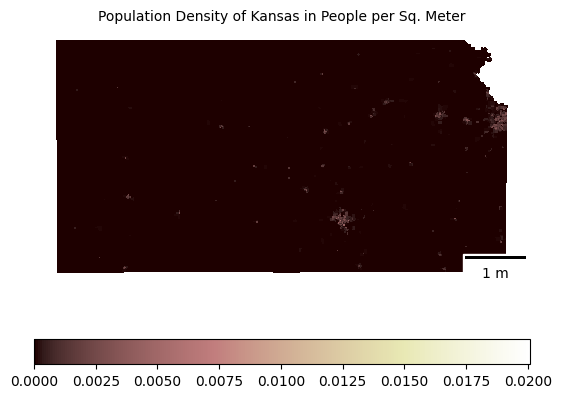

In [37]:
# Plot data
fig,ax=plt.subplots()
KS_Pop.plot(column='PopDens',legend=True,cmap='pink',ax=ax,legend_kwds={'location':'bottom'},antialiased=False)

#Finalize and save
ax.axis('off')
plt.title('Population Density of Kansas in People per Sq. Meter',fontdict={'fontsize': 10})
ax.add_artist(ScaleBar(1,location='lower right'))
fig.savefig('Population Density.png')

## Annual Precipitation

In [38]:
# Get annual precipitation totals
!wget 'https://tufts.box.com/shared/static/whdmmxe2guifgcou5ho9w5ko0gn7lwgo.zip'
zipfile.ZipFile('/content/whdmmxe2guifgcou5ho9w5ko0gn7lwgo.zip').extractall(path='AnnualPrecipitation')

--2024-04-22 18:20:35--  https://tufts.box.com/shared/static/whdmmxe2guifgcou5ho9w5ko0gn7lwgo.zip
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/whdmmxe2guifgcou5ho9w5ko0gn7lwgo.zip [following]
--2024-04-22 18:20:35--  https://tufts.box.com/public/static/whdmmxe2guifgcou5ho9w5ko0gn7lwgo.zip
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/whdmmxe2guifgcou5ho9w5ko0gn7lwgo.zip [following]
--2024-04-22 18:20:35--  https://tufts.app.box.com/public/static/whdmmxe2guifgcou5ho9w5ko0gn7lwgo.zip
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

In [39]:
# Read files
annual_precip = pd.read_csv('/content/AnnualPrecipitation/AnnualPrecipitation/PrecipTotal-2023.csv')
UScounties = gpd.read_file('/content/AnnualPrecipitation/AnnualPrecipitation/tl_2023_us_county.shp')

In [42]:
# Only use KS counties
KS_counties = UScounties[UScounties['STATEFP'] == '20']

In [44]:
# Join the data together
KS_counties_precip = KS_counties.merge(annual_precip, left_on='NAME',right_on='County')

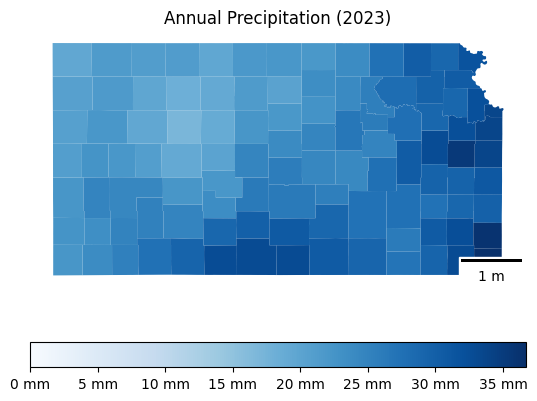

In [46]:
# Plot precipitation data
fig,ax=plt.subplots()
KS_counties_precip.plot(column='Total',legend=True,legend_kwds={'location':'bottom','format':'%i mm'},cmap='Blues',ax=ax,vmin=0)
ax.axis('off')
plt.title('Annual Precipitation (2023)',fontdict={'fontsize': 12})
ax.add_artist(ScaleBar(1,location='lower right'))
fig.savefig('Precipitation.png')

# Export to ArcGIS for reprojecting, rasterizing, and resampling

In [48]:
# Export precipitation data as shapefile
KS_counties_precip.to_file('KS_Counties.shp')

In [49]:
# Export popultation density as shapefile
KS_Pop.to_file('PopDens.shp')

In [50]:
# Export land cover data
with rio.open('/content/LandCover/nlcd_2021_land_cover_l48_20230630.img') as src:
    out_meta = src.meta
    out_image, out_transform = rio.mask.mask(src, shapes=KS_StateMap.to_crs(src.crs).geometry, crop=True)


    profile = src.profile
    profile["height"] = out_image.shape[1]
    profile["width"] = out_image.shape[2]
    profile["transform"] = out_transform


    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open("Ks_NLCD.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [51]:
# Export mosaic of DEM
with rio.open('/content/DEM/ASTGTMV003_N36W094_dem.tif') as src:
    out_meta = src.meta
    profile = src.profile
    profile["height"] = mosaic.shape[1]
    profile["width"] = mosaic.shape[2]
    profile["transform"] = out_trans


    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open("mosaic.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [52]:
# Export wind speed data
with rio.open('/content/USA_wind-speed_10m.tif') as src:
    out_meta = src.meta
    out_image, out_transform = rio.mask.mask(src, shapes=KS_StateMap.to_crs(4326).geometry, crop=True)


    profile = src.profile
    profile["height"] = out_image.shape[1]
    profile["width"] = out_image.shape[2]
    profile["transform"] = out_transform


    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open("wind2023.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [53]:
#Will clean and reproject in ArcGIS
#See ArcPy notebook here: https://tufts.box.com/shared/static/4gwnz8xlch37qkyh8q6j9zg18ckactux.ipynb

# Land Cover = 10%
# Elevation - 5%
# Distance to Power Lines - 30%
# Population - 10%
# Rainfall - 5%
# Wind Speed - 40%

#Classic Suitability Analysis in ArcPy

With counties outlines: https://tufts.box.com/s/40sj0pld19p6s1h62l9tahpf0adbg0wh

Without counties outlines: https://tufts.box.com/s/6tkk4v96feeu90ab227imgkb3jqyuzw9

# Spatial Random Forest

## Setup and bring in cleaned data

In [54]:
# Get rid of no data (-9999) values
KansasWindTurbines_Reprojected=KansasWindTurbines_Reprojected[KansasWindTurbines_Reprojected['p_cap']>0]

In [55]:
# Calculate average capacity of wind turbine from total proiject capacity divided from number of turbines
KansasWindTurbines_Reprojected['Avg_Cap']=KansasWindTurbines_Reprojected['p_cap']/KansasWindTurbines_Reprojected['p_tnum']

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [56]:
# Extract only columns interest
sites = KansasWindTurbines_Reprojected[['Avg_Cap','geometry']]

<Axes: >

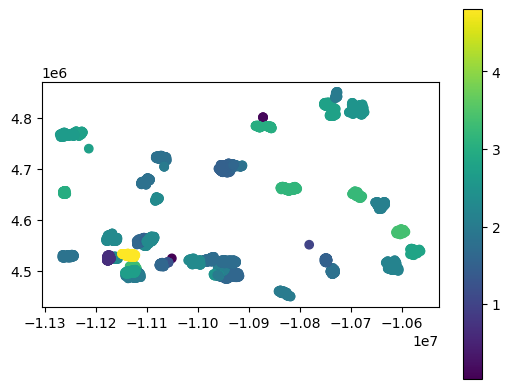

In [57]:
# Plot data
sites.plot(column='Avg_Cap',cmap='viridis',legend=True)

In [58]:
# Extract coordinate info from geometry column
sites['x'] = sites['geometry'].x
sites['y'] = sites['geometry'].y

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [59]:
# Extract raster data from each of the 6 rasters for the locations of the turbines
sites.index = range(len(sites))
coords = [(x,y) for x, y in zip(sites.x, sites.y)]
src1 = rio.open('/content/Cleaned Data/DEM_Cleaned.tif')
src2 = rio.open('/content/Cleaned Data/Distance_PL.tif')
src3 = rio.open('/content/Cleaned Data/KS_NLCD_Cleaned.tif')
src4 = rio.open('/content/Cleaned Data/PopDensity.tif')
src5 = rio.open('/content/Cleaned Data/Precip.tif')
src6 = rio.open('/content/Cleaned Data/wind2023_proj.tif')

sites['DEM'] = [x[0] for x in src1.sample(coords)]
sites['Dist_PL']= [x[0] for x in src2.sample(coords)]
sites['LC']= [x[0] for x in src3.sample(coords)]
sites['PopDens'] = [x[0] for x in src4.sample(coords)]
sites['Precip'] = [x[0] for x in src5.sample(coords)]
sites['Wind']= [x[0] for x in src6.sample(coords)]

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [60]:
# Drop geometry column because just need the coordinates
sites=sites.drop('geometry',axis=1)

In [62]:
# Determine number of sites in test and train sets
frac_test=0.3
rng = np.random.default_rng(seed=121)
L=sites.shape[0]
M=int(L*(1-frac_test))
N=int(L*frac_test)

In [63]:
# Randomly select the indices for the needed number of examples from the set for train
train_indices=rng.choice(np.arange(0,L), size = M, replace = False, p = None)

# The test indices are the other rows that were not selected
test_indices=np.arange(0,L)[~np.isin(np.arange(0,L),train_indices)]

# Use indices to generate final arrays
train=sites.iloc[train_indices]
test=sites.iloc[test_indices]

In [66]:
# Prepare data function from SPRF demo notebook on GitHub
def prepare_data(data, target, lon="x", lat="y"):
    """Assumes that all other columns are used as covariates"""
    covariates = [col for col in data.columns if col not in [lon, lat, target]]
    return data[covariates], data[target], data[[lon, lat]]

In [67]:
# split into x, y, and coordinates
train_x, train_y, train_coords = prepare_data(
    train, 'Avg_Cap'
)
test_x, test_y, test_coords = prepare_data(
    test, 'Avg_Cap'
)

In [68]:
# Setting starting hyperparamaters for RF
n_estimators = 100
max_depth = 10
spatial_neighbors = len(sites) // 5

In [69]:
# Training and testing basic RF
rf = RandomForestRegressor(max_depth=max_depth)
rf.fit(train_x, train_y)
test_pred_rf = rf.predict(test_x)

rmse_rf = mean_squared_error(test_pred_rf, test_y, squared=False)
print("Error of basic Random Forest: ", rmse_rf)

Error of basic Random Forest:  0.22566284332125122


In [70]:
# Training and testing spatial RF
sp = SpatialRandomForest(
    max_depth=max_depth, neighbors=spatial_neighbors
)
sp.fit(train_x, train_y, train_coords)
test_pred_sp = sp.predict(test_x, test_coords)

rmse_spatial_rf = mean_squared_error(test_pred_sp, test_y, squared=False)
print("Error of spatial Random Forest: ", rmse_spatial_rf)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Error of spatial Random Forest:  0.33305543708344804


In [71]:
# Tuning spatial random forest for number of neighbors
regr = SpatialRandomForest(
        n_estimators=n_estimators, neighbors=500, max_depth=max_depth
    )
regr.tune_neighbors(train_x, train_y, train_coords)
print("spatial rf tuned:", regr.neighbors)
regr.fit(train_x, train_y, train_coords)
test_pred_tune = regr.predict(test_x, test_coords)
rmse_spatial_rf_tuned = mean_squared_error(test_pred_tune, test_y, squared=False)
print("Error of tuned spatial Random Forest: ", rmse_spatial_rf_tuned)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

spatial rf tuned: 2498


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Error of tuned spatial Random Forest:  0.26790587540125854


In [72]:
# Storing predictions on test dataset from each of the 3 RF models
test['RFPrediction']=test_pred_rf
test['SPRFPrediction']=test_pred_sp
test['TunePrediction']=test_pred_tune

<ipython-input-72-7fe65372d85b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['RFPrediction']=test_pred_rf
<ipython-input-72-7fe65372d85b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SPRFPrediction']=test_pred_sp
<ipython-input-72-7fe65372d85b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [73]:
# Converting data into geodataframe for mapping
test_gdf = gpd.GeoDataFrame(
    test, geometry=gpd.points_from_xy(test.x, test.y), crs="EPSG:3857"
)

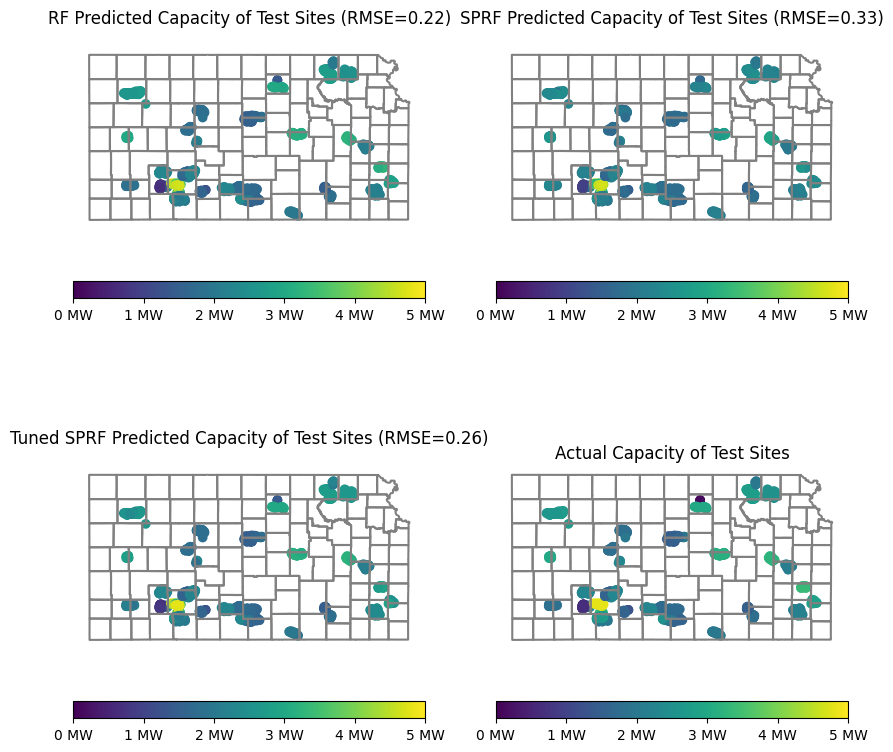

In [74]:
# Plotting predictions of each of the 3 models and the actual value from the USWTDB
fig,ax=plt.subplots(2,2,figsize=(10,10))

test_gdf.plot(column='RFPrediction',ax=ax[0,0],legend=True,legend_kwds={'location':'bottom','format':'%i MW'},vmin=0,vmax=5)
KS_counties.to_crs(epsg=3857).boundary.plot(ax=ax[0,0], color = 'gray')
ax[0,0].axis('off')
ax[0,0].set_title('RF Predicted Capacity of Test Sites'+' (RMSE='+str(rmse_rf)[:4]+')')

test_gdf.plot(column='SPRFPrediction',ax=ax[0,1],legend=True,legend_kwds={'location':'bottom','format':'%i MW'},vmin=0,vmax=5)
KS_counties.to_crs(epsg=3857).boundary.plot(ax=ax[0,1], color = 'gray')
ax[0,1].axis('off')
ax[0,1].set_title('SPRF Predicted Capacity of Test Sites'+' (RMSE='+str(rmse_spatial_rf)[:4]+')')

test_gdf.plot(column='TunePrediction',ax=ax[1,0],legend=True,legend_kwds={'location':'bottom','format':'%i MW'},vmin=0,vmax=5)
KS_counties.to_crs(epsg=3857).boundary.plot(ax=ax[1,0], color = 'gray')
ax[1,0].axis('off')
ax[1,0].set_title('Tuned SPRF Predicted Capacity of Test Sites'+' (RMSE='+str(rmse_spatial_rf_tuned)[:4]+')')

test_gdf.plot(column='Avg_Cap',ax=ax[1,1],legend=True,legend_kwds={'location':'bottom','format':'%i MW'},vmin=0,vmax=5)
KS_counties.to_crs(epsg=3857).boundary.plot(ax=ax[1,1], color = 'gray')
ax[1,1].axis('off')
ax[1,1].set_title('Actual Capacity of Test Sites')

fig.savefig('Predicted Capacity.png')

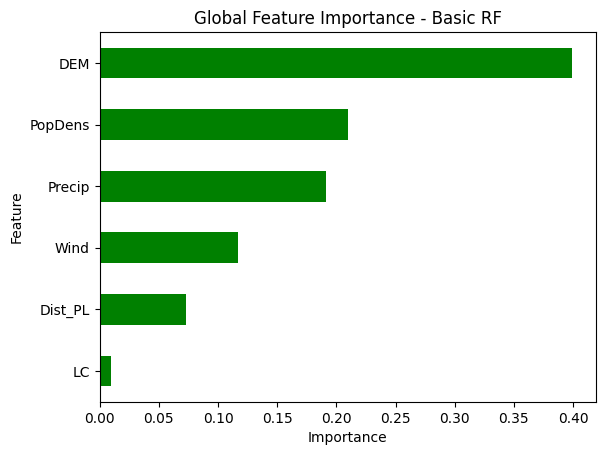

In [75]:
# Generating plot of feature importance from basic RF (not available for 2 spatial models)
global_importances = pd.Series(rf.feature_importances_, index=train_x.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances[-10:].plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Basic RF")
plt.savefig('Feature Importance.png')

## Create Points for each pixel in raster

Will generate a square tesselation in ArcGIS but for 600 x 600m squares to reduce storage size and then generate their centroids and import as prediction sites (still took 40+ mins)

In [ ]:
# You can see the ArcPy script at the earlier link where this tesselation was done

## Predict with RF regressor

In [76]:
# Download validation points generated in ArcGIS
!wget https://tufts.box.com/shared/static/2nw88pxderrdcadkcwo16y08t7shaxn2.zip
zipfile.ZipFile('2nw88pxderrdcadkcwo16y08t7shaxn2.zip').extractall('/content/ValidationPoints')

--2024-04-22 18:21:33--  https://tufts.box.com/shared/static/2nw88pxderrdcadkcwo16y08t7shaxn2.zip
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/2nw88pxderrdcadkcwo16y08t7shaxn2.zip [following]
--2024-04-22 18:21:33--  https://tufts.box.com/public/static/2nw88pxderrdcadkcwo16y08t7shaxn2.zip
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/2nw88pxderrdcadkcwo16y08t7shaxn2.zip [following]
--2024-04-22 18:21:33--  https://tufts.app.box.com/public/static/2nw88pxderrdcadkcwo16y08t7shaxn2.zip
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

In [77]:
# Read validation points
validation=gpd.read_file('/content/ValidationPoints/AllPts.shp',driver='pyogrio')[['geometry']].clip(KS_StateMap.to_crs(3857).geometry)

In [78]:
# Extract x and y coordinates (in EPSG 3867) for each validation point
validation['x'] = validation['geometry'].x
validation['y'] = validation['geometry'].y

In [79]:
# Extract values of the 6 rasters at each of the validation points
validation.index = range(len(validation))
coords = [(x,y) for x, y in zip(validation.x, validation.y)]
src1 = rio.open('/content/Cleaned Data/DEM_Cleaned.tif')
src2 = rio.open('/content/Cleaned Data/Distance_PL.tif')
src3 = rio.open('/content/Cleaned Data/KS_NLCD_Cleaned.tif')
src4 = rio.open('/content/Cleaned Data/PopDensity.tif')
src5 = rio.open('/content/Cleaned Data/Precip.tif')
src6 = rio.open('/content/Cleaned Data/wind2023_proj.tif')

validation['DEM'] = [x[0] for x in src1.sample(coords)]
validation['Dist_PL']= [x[0] for x in src2.sample(coords)]
validation['LC']= [x[0] for x in src3.sample(coords)]
validation['PopDens'] = [x[0] for x in src4.sample(coords)]
validation['Precip'] = [x[0] for x in src5.sample(coords)]
validation['Wind']= [x[0] for x in src6.sample(coords)]

In [80]:
# Drop the geometry column and any NaN (these were points outside of the raster extents)
validation=validation.drop('geometry',axis=1).dropna()

In [81]:
# Get rid of no data values in each raster by only using the positive values of each of these rasters
validation=validation[validation['Precip']>0]
validation=validation[validation['PopDens']>0]
validation=validation[validation['Dist_PL']>0]

In [82]:
# Split into predictors (x) and coords for predicting with 3 models
validation_x=validation.drop(['x','y'],axis=1)
validation_coords=validation[['x','y']]

In [83]:
# Predict values with each of the models
rf_pred = rf.predict(validation_x)
sp_pred=sp.predict(validation_x,validation_coords)
tu_pred=regr.predict(validation_x,validation_coords)

# Store values in dataframe
validation['RFPrediction']=rf_pred
validation['SPPrediction']=sp_pred
validation['TUPrediction']=tu_pred

In [84]:
# convert to geodataframe
map_gdf = gpd.GeoDataFrame(
    validation, geometry=gpd.points_from_xy(validation.x, validation.y), crs="EPSG:3857"
)

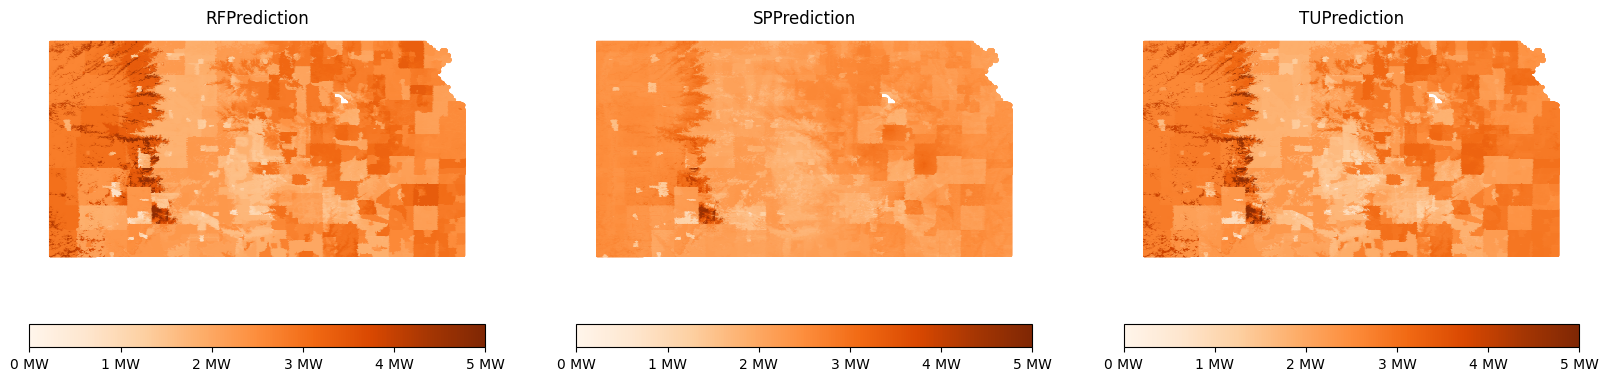

In [85]:
# Generate final predictive maps
fig,ax=plt.subplots(1,3,figsize=(20,5))
j=0
for i in ['RFPrediction','SPPrediction','TUPrediction']:
    map_gdf.plot(column=i,cmap='Oranges',ax=ax[j],legend=True,legend_kwds={'location':'bottom','format':'%i MW'},vmin=0,vmax=5,markersize=0.5)
    ax[j].set_title(i)
    ax[j].axis('off')
    j+=1
fig.savefig('Prediction Results.png')